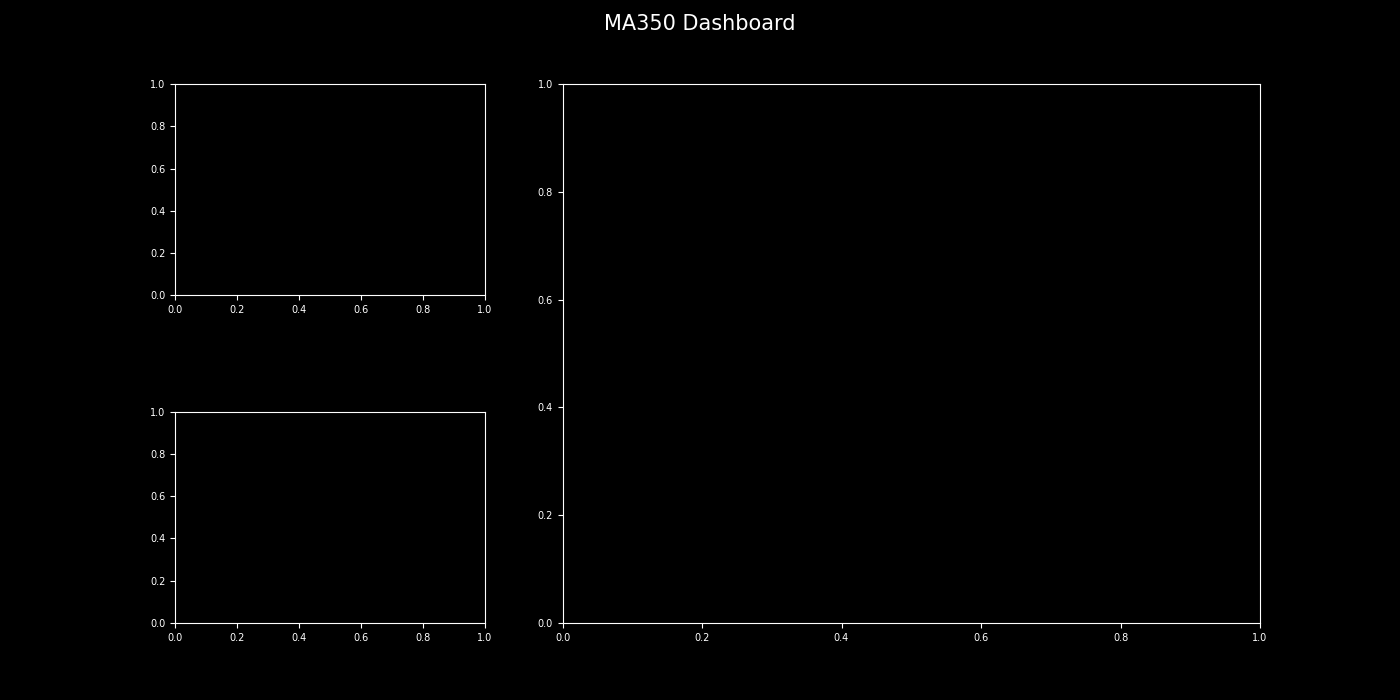

In [1]:
%matplotlib ipympl 
#matplotlib interactive for IPython

#import libraries and functions
import pandas as pd
import math
import ipywidgets, asyncio, time
from datetime import datetime
import matplotlib.pyplot as plt # to make mpl faster
import matplotlib as mpl # to make mpl faster
import numpy as np #numpy for tons of stuff
import matplotlib.style as mplstyle
mpl.rcParams['path.simplify_threshold'] = 1.0 # to make mpl faster
mplstyle.use('fast') # to make mpl faster
import AlicatMFC as alicat #main python file to use functions from there
from scipy.signal import savgol_filter # savgol filter for smoothing

#styles to limit the description width
numberStyle = {'description_width': "33%"}
numberstyle2  = {'description_width': "40%"}
itemLayout = ipywidgets.Layout(width = "auto",height = "30px")

def colLayout(wid):
    return ipywidgets.Layout(display = "flex",flex_flow='column',border = '1px solid black',align_items = "stretch",justify_content="flex-start",width = wid)

#create widgets
running = ipywidgets.ToggleButton(description="start", icon="play",button_style = 'danger', layout = itemLayout) #whether program is running or not
xlim = ipywidgets.IntSlider(description="xlim", value=1000, min=10, max=16000, step = 10, layout = itemLayout) #number of x values on matplotlib plots
ylim = ipywidgets.IntRangeSlider(description="ylim", value=[-5000,30000], min=-30000, max=100000, layout = itemLayout) #y range for matplotlib plots

timeBase = ipywidgets.FloatText(description = "Timebase", value = 1,layout = itemLayout) #MA350 timebase
ewmNum = ipywidgets.IntText(description="EWM COM",value = 30, layout = itemLayout) #exponential mean weighting
tapePosition = ipywidgets.FloatText(description = "Tape Position", layout = itemLayout) #MA350
flowSetpoint = ipywidgets.FloatText(description = "Flow Setpoint", layout = itemLayout) #MA350
aethCOM = ipywidgets.Dropdown(description = "Bc COM",options = ['COM5','COM8'],value = "COM5",layout = itemLayout) #com port for the black carbon measurement
baudrate = ipywidgets.IntText(description="baudrate",value = 1000000, layout = itemLayout)

plotTime = ipywidgets.Textarea(description="plot time", layout = itemLayout) #time to plot each matplotlib group
totalTime = ipywidgets.Textarea(description="run time", layout = itemLayout) #total time
elapsedInterval = ipywidgets.Textarea(description="interval", layout = itemLayout) #elapsed time per main loop (should average 1.000 seconds)
currentData = ipywidgets.Textarea(description="data", layout = itemLayout) #displays current data from MA350 or PAX


#bcc values
IRBc1 = ipywidgets.FloatText(description="IR Bc1", layout = itemLayout)
IRBcc = ipywidgets.FloatText(description="IR Bcc", layout = itemLayout)
Bc1EWM = ipywidgets.FloatText(description="ewm 1", layout = {'width':'45%'}, style = numberStyle)
BccEWM = ipywidgets.FloatText(description="ewm c", layout = {'width':'45%'}, style = numberStyle)
savgol1 = ipywidgets.FloatText(description="sav 1", layout = {'width':'45%'}, style = numberStyle)
savgolc = ipywidgets.FloatText(description="sav c", layout = {'width':'45%'}, style = numberStyle)
bc1 = ipywidgets.HBox(children = [Bc1EWM,savgol1], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))
bcc = ipywidgets.HBox(children = [BccEWM,savgolc], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

#checkboxes to show different elements of black carbon plot
showBcc = ipywidgets.Checkbox(value = True, description = "Bcc", layout = itemLayout,indent = False)
showEWM = ipywidgets.Checkbox(value = True, description = "EWM", layout = itemLayout,indent = False)
showSavgol = ipywidgets.Checkbox(value = False, description = "savgol", layout = itemLayout,indent = False)
show = ipywidgets.HBox(children = [showBcc,showEWM,showSavgol], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

#create widget layout
col1 = ipywidgets.VBox(children = [running,xlim,ylim,ewmNum],layout = colLayout("20%"))
col2 = ipywidgets.VBox(children = [timeBase,tapePosition,flowSetpoint,aethCOM,baudrate],layout = colLayout("15%"))
col4 = ipywidgets.VBox(children = [IRBc1,IRBcc,bc1,bcc,show],layout = colLayout("18%"))
col5 = ipywidgets.VBox(children = [plotTime,totalTime,elapsedInterval,currentData],layout = colLayout("20%"))
ui = ipywidgets.HBox([col1,col2,col4,col5],layout=ipywidgets.Layout(width = "1400px"))

#for managing asyncronous ts=asks
tasks = dict()

#create global panda dataframes
dfAeth =  pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],columns=['timebase', 'tape position', 'flow setpoint', 'flow total', 'sample temp', 'sample rh', 'sample dewpoint', 'uv atn1', 'uv atn2', 'ir atn1', 'ir atn2', 'ir bc1', 'ir bcc',"bc1 ewm","bcc ewm","humidity"])

#measure runtime and elapsed time per loop
times = [time.time()]
startTime = time.time()
    
#update all matplotlib plots and get instrument data
async def update_plots(t,recent):
    run = False
    
    #get aeth data, and account for the possibility that it will get a 0
    aethData = alicat.getMicroAethData()
    if timeBase.value < 2:
        #if the serial reading is off, use the last loop's data and reset the loop so timebase and loop interval align
        if (len(aethData) != 14):
            aethData = recent
            time.sleep(timeBase.value + 0.1)
        else:
            aethData = aethData + [0,0]
            run = True
    else:
        if len(aethData) == 14:
            aethData = aethData + [0,0]
            run = True
        else: run = False
        
    if run:
        #display raw data from MA350
        currentData.value = ', '.join(str(val) for val in aethData)

        #concatenate the new data to the original dataframe
        aethData = [aethData]
        dfNewAeth = pd.DataFrame(aethData, columns=['timebase', 'tape position', 'flow setpoint', 'flow total', 'sample temp', 'sample rh', 'sample dewpoint', 'uv atn1', 'uv atn2', 'ir atn1', 'ir atn2', 'ir bc1', 'ir bcc',"bc1 ewm","bcc ewm","humidity"])
        global dfAeth
        dfAeth = pd.concat([dfAeth,dfNewAeth],ignore_index = True)

        #get exponentially weighted means and add to dataframe
        index = len(dfAeth.index)-1
        if ewmNum.value > index:
            dfAeth["bc1 ewm"] = dfAeth["ir bc1"].ewm(com = index).mean()
            dfAeth["bcc ewm"] = dfAeth["ir bcc"].ewm(com = index).mean()
        else:
            dfAeth["bc1 ewm"] = dfAeth["ir bc1"].ewm(com =  ewmNum.value).mean()
            dfAeth["bcc ewm"] = dfAeth["ir bcc"].ewm(com =  ewmNum.value).mean()
        
    index = len(dfAeth.index)-1
    for ax in axes.keys():
        axes[ax].clear()
        xlim.min = 0
        xlim.max = 16000/timeBase.value
        xlim.step = int(200/timeBase.value)
        axes[ax].set_xlim(index+1-xlim.value,index+1)

    #settings for bcc graph
    axes["C"].grid()
    axes["C"].set_ylim(ylim.value)

    #update each plot 
    axes["A"].plot(dfAeth["sample rh"], label = "RH", color = "orange")
    axes["A"].plot(dfAeth["sample temp"], label = "Temp", color = "red")
    axes["A"].plot(dfAeth["sample dewpoint"], label = "Dewpoint", color = "green")
    axes["A"].plot(dfAeth["humidity"]*100, label = "Humidity", color = "blue")

    axes["B"].plot(dfAeth["uv atn1"], label = "UV ATN1", color = "pink")
    axes["B"].plot(dfAeth["uv atn2"], label = "UV ATN2", color = "red")
    axes["B"].plot(dfAeth["ir atn1"], label = "IR ATN1", color = "orange")
    axes["B"].plot(dfAeth["ir atn2"], label = "IR ATN2", color = "yellow")

    if showBcc.value:
        axes["C"].plot(dfAeth["ir bcc"], label = "IR BCC", color = "darkviolet")
        axes["C"].plot(dfAeth["ir bc1"], label = "IR BC1", color = "blue")
    if showEWM.value:
        axes["C"].plot(dfAeth["bcc ewm"], label = "BCC EWM", color = "orchid")
        axes["C"].plot(dfAeth["bc1 ewm"], label = "BC1 EWM", color = "darkturquoise")
    if index > 30:
        w = 30
    else:
        w = index-1
    #show savgol smoother plot of bcc values
    if showSavgol.value:
        axes["C"].plot(savgol_filter(dfAeth["bcc ewm"].to_numpy(), w, 4),label = "bcc savgol",color = "magenta")
        axes["C"].plot(savgol_filter(dfAeth["bc1 ewm"].to_numpy(), w, 4),label = "bc1 savgol",color = "cyan")
        savgolc.value = round(savgol_filter(dfAeth["bcc ewm"].to_numpy(), w, 4)[-1],1)
        savgol1.value = round(savgol_filter(dfAeth["bc1 ewm"].to_numpy(), w, 4)[-1],1)

    axes["A"].set_title("Aeth Miscelaneous")
    axes["B"].set_title("Attenuations")
    axes["C"].set_title("BCC Values")

        #set legends
    for ax in axes.keys():
        axes[ax].legend(loc = "upper left",fancybox = True,framealpha = 0.4)

    #track plotting time 
    startPlot = time.time()
    fig.canvas.draw() #draw and flush the new figure elements without fully starting a new figure with new axes
    fig.canvas.flush_events()
    plotTime.value = str(round(time.time()-startPlot,4))

    #update time widgets
    times.append(time.time())
    elapsedInterval.value = f"{t}: {round(times[-1]-times[-2],4)}"
    totalTime.value = str(round(time.time() - startTime,4))

    #update numerical black carbon widgets
    IRBcc.value = dfAeth.iat[index,12]
    IRBc1.value = dfAeth.iat[index,11]
    BccEWM.value = round(dfAeth.iat[index,14],1)
    Bc1EWM.value = round(dfAeth.iat[index,13],1)
    tapePosition.value = dfAeth.iat[index,1]
    flowSetpoint.value = dfAeth.iat[index,2]

def saveToPickle():
    dt_string = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
    inttime = str(int(float(totalTime.value)))
    dfAeth.to_pickle(f"C:\\Users\\Kyan Shlipak\\Documents\\MA350 file {dt_string} runtime {inttime}.pkl")


#get timebase for main loop interval
def setupAethTimebase():
    while True:
        aethData = alicat.getMicroAethData()
        print(aethData)
        if len(aethData) == 14:
            if aethData[0] != 0:
                timeBase.value = aethData[0]
                break
        else:
            time.sleep(0.4)
        
#run main loop of asyncronous coroutines
async def do_loop():
    t=0
    setupAethTimebase()
    while running.value:
        print(running)
        recent = dfAeth.iloc[-1].tolist()
        asyncio.get_event_loop().create_task(update_plots(t,recent))
        t += 1
        await asyncio.sleep(0.993)

#stop or start main loop according to the start/stop button
def on_running_changed(*change):
    task = tasks.pop("do_loop", None)
   
    if task:
        task.cancel()
        saveToPickle()
        alicat.closeAethPort()

    if running.value:
        elapsedInterval.value = "starting..."
        alicat.openAethPort(aethCOM.value,baudrate.value)
        time.sleep(0.1)
        tasks["do_loop"] = asyncio.get_event_loop().create_task(do_loop())

#customize plot font sizes
plt.rc('axes',titlesize=10)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize = 8)
plt.rc('figure',titlesize = 15)
plt.style.use('dark_background')


#create "mosaic" customizing grid layout. Semicolons separate rows
fig,axes = plt.subplot_mosaic("ACC;BCC")
fig.set_size_inches(14,7)
fig.suptitle("MA350 Dashboard")
plt.tight_layout
plt.subplots_adjust(wspace =0.25,hspace = 0.55)
plt.ion()
fig.canvas.draw()

#observe stop/start button
running.observe(on_running_changed, "value")

#display UI (widget grid)
ui

In [2]:
xlim.min = 0
xlim.max = 16000/timeBase.value
xlim.step = int(200/timeBase.value)